In [ ]:
!nvidia-smi

Thu Apr 28 03:39:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#$First-Preprocessing-Teach$

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
FIG_SIZE = (15,10)
file = "./drive/MyDrive/music/genres/blues/blues.00000.wav"

Text(0.5, 1.0, 'Waveform')

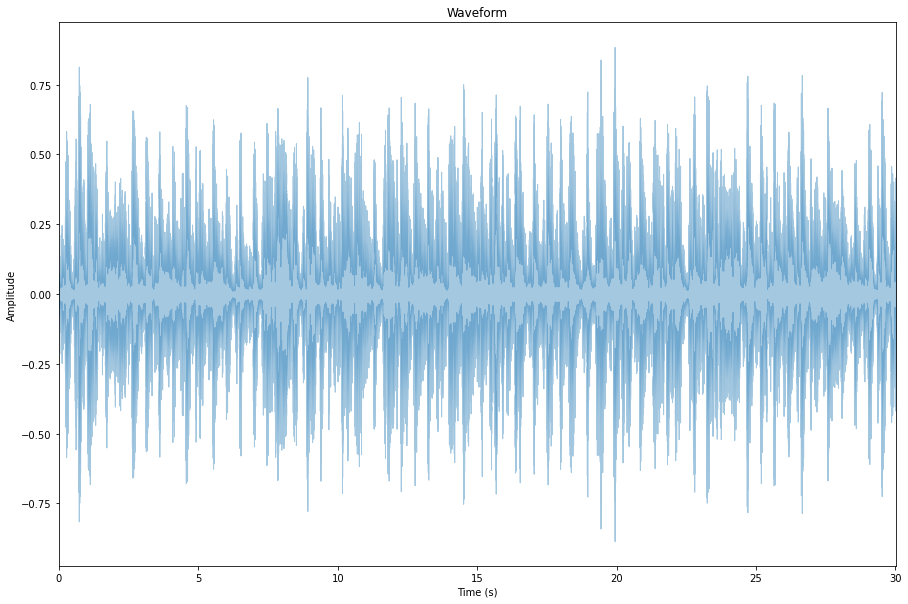

In [ ]:
# load audio file with Librosa
signal, sample_rate = librosa.load(file, sr=22050)
# WAVEFORM
# display waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Text(0.5, 1.0, 'Power spectrum')

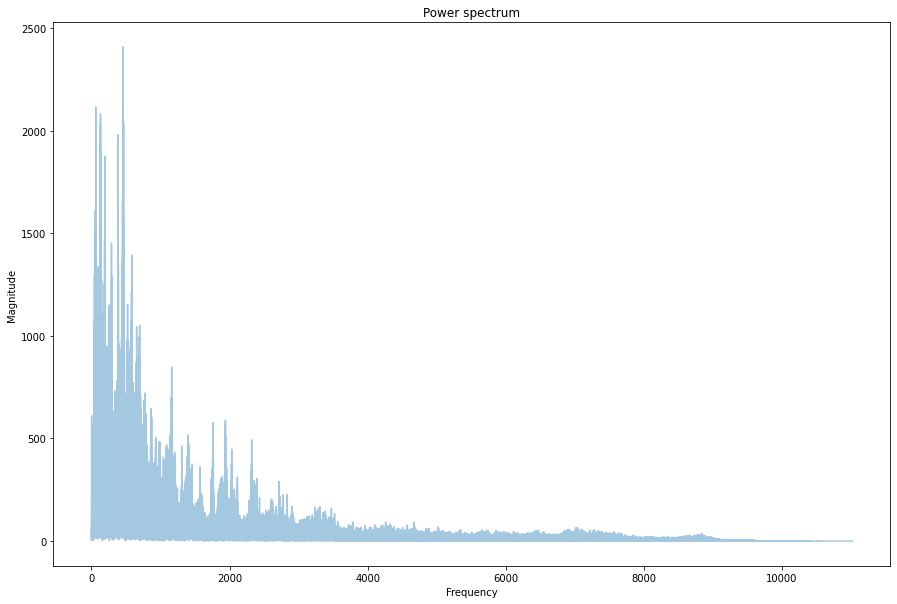

In [ ]:
# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

In [ ]:
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


In [ ]:
# y, sr = librosa.load(songname, duration=30)
melgram = librosa.feature.melspectrogram(y=signal, sr=sample_rate,hop_length=hop_length, n_fft=n_fft, n_mels=96)
D = np.abs(librosa.stft(signal))**2 # short time fourier transform
S = librosa.feature.melspectrogram(S=D, sr=sample_rate)
S = librosa.amplitude_to_db(S)

Text(0.5, 1.0, 'Spectrogram (dB)')

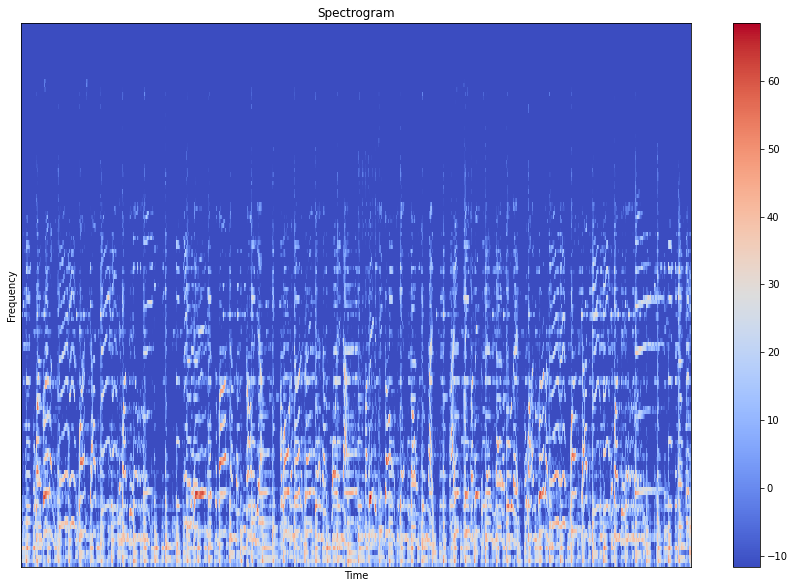

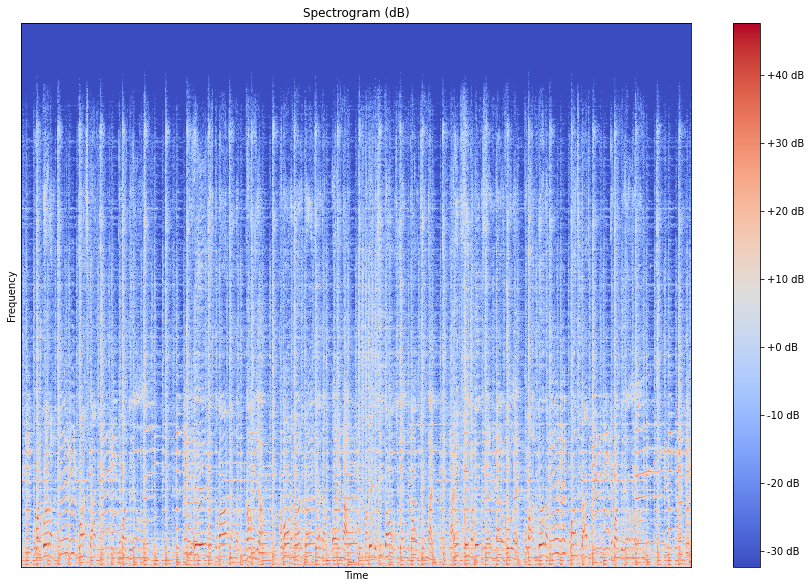

In [ ]:
# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(S, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

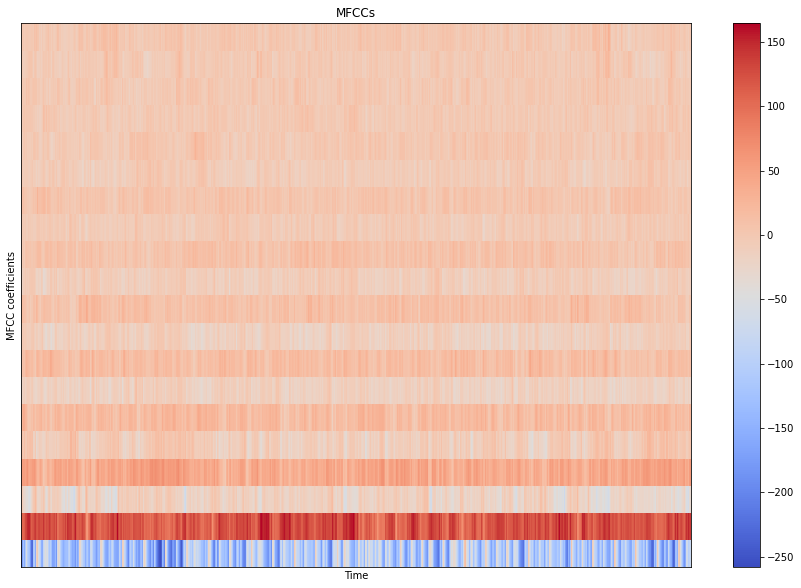

In [ ]:
# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

#$Prepare-Data-for-Music-Genre-Classification$

In [ ]:
import json
import os
import math
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

DATASET_PATH = "./drive/MyDrive/music/genres"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

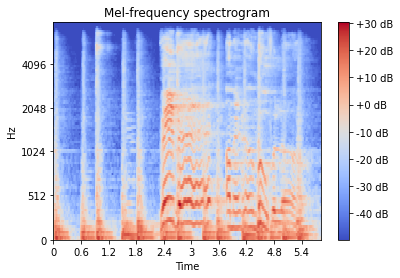

In [ ]:
signal, sample_rate = librosa.load( "./drive/MyDrive/music/genres/blues/blues.00001.wav", sr=SAMPLE_RATE)
melgram = librosa.feature.melspectrogram(signal[0:128000], sample_rate, hop_length=512, n_fft=2048, n_mels=96)
fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(melgram)
S_dB = librosa.power_to_db(melgram)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=SAMPLE_RATE, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
22050*30/512

1291.9921875

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=1, n_mels=96):
  """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :param: num_segments (int): Number of segments we want to divide sample tracks into
    :return:
  """

  # dictionary to store mapping, labels, and MFCCs
  data = {
    "mapping": [],
    "labels": [],
    "mfcc": []
  }
  melgrams = np.zeros((0, 130, 35))
  labels = []
  samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # 661500/num_segments
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # 130( math.ceil無條件進位 )
  i = 0
  # loop through all genre sub-folder
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    # ensure we're processing a genre sub-folder level
    if dirpath is not dataset_path:

      # save genre label (i.e., sub-folder name) in the mapping
      semantic_label = dirpath.split("/")[-1]
      data["mapping"].append(semantic_label) # 'blues'分類用
      print("\nProcessing: {}".format(semantic_label))

      # process all audio files in genre sub-dir
      for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # process all segments of audio file(分割音頻)
        for d in range(num_segments): # num_segments
          
          # calculate start and finish sample for current segment
          start = samples_per_segment * d
          finish = start + samples_per_segment
          print(signal[start:finish].shape)
          # 將音頻文件加載為浮點時間序列
          # data, _ = librosa.load(os.path.join(FLAGS.audio_dir, f"{audio_name}.wav"), sr=SR)
          # 計算光譜通量起始強度包絡(envelope)
          envelope = librosa.onset.onset_strength(signal[start:finish], sr=sample_rate)  # (seq_len,)
          # 梅爾頻率倒譜係數
          mfcc = librosa.feature.mfcc(signal[start:finish], sr=sample_rate, n_mfcc=20).T  # (seq_len, 20)
          # output length = (seconds) * (sample rate) / (hop_length)
          # 計算色度變體“色度能量歸一化”
          chroma = librosa.feature.chroma_cens( signal[start:finish], sr=sample_rate, hop_length=hop_length, n_chroma=12).T  # (seq_len, 12)
          # 通過在起始強度包絡中選取峰值來定位音符起始事件。
          peak_idxs = librosa.onset.onset_detect(
              onset_envelope=envelope.flatten(), sr=sample_rate, hop_length=hop_length)
          peak_onehot = np.zeros_like(envelope, dtype=np.float32)
          peak_onehot[peak_idxs] = 1.0  # (seq_len,)
          # 偵測節拍
          tempo, beat_idxs = librosa.beat.beat_track(
              onset_envelope=envelope, sr=sample_rate, hop_length=hop_length, tightness=100)
          beat_onehot = np.zeros_like(envelope, dtype=np.float32)
          beat_onehot[beat_idxs] = 1.0  # (seq_len,)

          audio_feature = np.concatenate([
            envelope[:, None], mfcc, chroma, peak_onehot[:, None], beat_onehot[:, None]
          ], axis=-1)[:-1] # (seq_len, 23)
          # print(audio_feature.shape)
          # extract mfcc
          # mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
          # mfcc = mfcc.T
          # melgram = librosa.feature.melspectrogram(signal[:661500], sample_rate, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
          # db: 分貝 將幅度譜圖轉換為分貝標度的譜圖
          # ret = librosa.power_to_db(melgram)
          # ret = librosa.amplitude_to_db(melgram)
          # ret = ret.T
          print(len(audio_feature),num_mfcc_vectors_per_segment)
          # store only mfcc feature with expected number of vectors
          if len(audio_feature) == num_mfcc_vectors_per_segment:
            audio_feature = audio_feature[np.newaxis,:,:]
            # print(audio_feature.shape)
            melgrams = np.concatenate((melgrams, audio_feature), axis=0)
            labels.append(i-1)
            # data["mfcc"].append(ret.tolist())
            # data["labels"].append(i-1)
            print("{}, segment:{}".format(file_path, d+1))
            # i+=1
    #       if i > 0:
    #         break
    #   if i > 0:
    #     break
    # if i > 0:
    #   break
  return melgrams, labels
  # save MFCCs to json file
  # with open(json_path, "w") as fp:
  #     json.dump(data, fp, indent=4)#indent:增加可讀性
  # len(data)

In [ ]:
melgrams, labels= save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [ ]:
labels = np.array(labels)
melgrams.shape, np.array(labels).shape

((9996, 130, 35), (9996,))

In [ ]:
np.save('./drive/MyDrive/data/music_mfcc_beat/melgrams.npy',melgrams)
np.save('./drive/MyDrive/data/music_mfcc_beat/labels.npy',labels)

In [ ]:
melgrams = np.load('./drive/MyDrive/data/music_mint_mfcc/melgrams.npy')
labels = np.load('./drive/MyDrive/data/music_mint_mfcc/labels.npy')
melgrams.shape, labels.shape

((770, 180, 18), (770,))

In [ ]:
melgrams = np.load('./melgrams.npy')
labels = np.load('./labels.npy')
melgrams.shape, labels.shape

((771, 180, 18), (771,))

In [ ]:
melgrams.min()

-1.0

#$DNN-for-Music-Genre-Classification$

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "drive/MyDrive/data/data_10.json"

def load_data(data_path):
  """Loads training dataset from json file.
      :param data_path (str): Path to json file containing data
      :return X (ndarray): Inputs
      :return y (ndarray): Targets
  """

  with open(data_path, "r") as fp:
      data = json.load(fp)

  # convert lists to numpy arrays
  X = np.array(data["mfcc"])
  y = np.array(data["labels"])

  print("Data succesfully loaded!")

  return  X, y

In [ ]:
# load data
# X, y = load_data(DATA_PATH)
# create train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(melgrams, labels, test_size=0.3)
X_train.shape, X_test.shape

((699, 1292, 96), (300, 1292, 96))

In [ ]:
# build network topology
model = keras.Sequential([
  # input layer
  keras.layers.Flatten(input_shape=(melgrams.shape[1], melgrams.shape[2])),
  # 1st dense layer
  keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),
   # 2nd dense layer
  keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),
  # 3rd dense layer
  keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),
  # output layer
  keras.layers.Dense(10, activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=200)

In [ ]:
def plot_history(history):
  fig, axs = plt.subplots(2)
  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")
  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()

plot_history(history)

In [ ]:
pred = model.predict(X_test)

In [ ]:
import seaborn as sns
import tensorflow as tf
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
y_pred = np.argmax(pred, axis=1)
# y_pred.shape
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=genres,
            yticklabels=genres,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#$CNN-for-Music-Genre-Classification$

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "drive/MyDrive/data/data_10.json"


def load_data(data_path):
  """Loads training dataset from json file.
      :param data_path (str): Path to json file containing data
      :return X (ndarray): Inputs
      :return y (ndarray): Targets
  """

  with open(data_path, "r") as fp:
      data = json.load(fp)

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  return X, y


def plot_history(history):
  """Plots accuracy/loss for training/validation set as a function of the epochs
      :param history: Training history of model
      :return:
  """

  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()

In [ ]:
def prepare_datasets(melgrams, labels, test_size, validation_size):
  """Loads data and splits it into train, validation and test sets.
  :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
  :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
  :return X_train (ndarray): Input training set
  :return X_validation (ndarray): Input validation set
  :return X_test (ndarray): Input test set
  :return y_train (ndarray): Target training set
  :return y_validation (ndarray): Target validation set
  :return y_test (ndarray): Target test set
  """
  # load data
  # X, y = load_data(DATA_PATH)

  # create train, validation and test split
  X_train, X_test, y_train, y_test = train_test_split(melgrams, labels, test_size=test_size)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

  # add an axis to input sets
  X_train = X_train[..., np.newaxis]
  X_validation = X_validation[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
  """Generates CNN model
  :param input_shape (tuple): Shape of input set
  :return model: CNN model
  """
  # build network topology
  model = keras.Sequential()
  # 1st conv layer
  model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.1))
  # 2nd conv layer
  model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(3, 3), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.1))
  # 3rd conv layer
  model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D((4, 4), strides=(4, 4), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))

  # 4th conv layer
  model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D((4, 4), strides=(4, 4), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))

  # flatten output and feed it into dense layer
  # model.add(keras.layers.Flatten())
  # model.add(keras.layers.Dense(64, activation='relu'))
  # model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Reshape((2, 128)))
  model.add(keras.layers.LSTM(32, input_shape=input_shape, return_sequences=True))
  model.add(keras.layers.LSTM(32))
  model.add(keras.layers.Dropout(0.3))
  # output layer
  model.add(keras.layers.Dense(10, activation='softmax'))

  return model


def predict(model, X, y):
  """Predict a single sample using the trained model
  :param model: Trained classifier
  :param X: Input data
  :param y (int): Target
  """
  # add a dimension to input data for sample - model.predict() expects a 4d array in this case
  X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
  # perform prediction
  prediction = model.predict(X)
  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)
  print("Target: {}, Predicted label: {}".format(y, predicted_index)) 

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(melgrams, labels, 0.2, 0.2)
X_train.shape, X_validation.shape, X_test.shape

((492, 180, 18, 1), (124, 180, 18, 1), (155, 180, 18, 1))

In [ ]:
from numpy.lib.npyio import save
import tensorflow as tf
# 定義 ModelCheckpoint callback
checkpoint_path = "./drive/MyDrive/model/music_classification/checkpoint/mfcc/cp-{epoch:04d}.ckpt"
callback_list = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    # save_freq='epoch' # 每batch數存一次
    ),]
    # tf.keras.callbacks.TensorBoard(log_dir='./checkpoint/logs/', histogram_freq=1, embeddings_freq=1)]

In [ ]:
X_train.shape[1], X_train.shape[2]

(180, 18)

In [ ]:
# create network
# input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape = (180, 18, 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
model.summary()

# train model
# history = model.fit(X_train, y_train, 
#             validation_data=(X_validation, y_validation), 
#             batch_size=32, 
#             epochs=200,
#             callbacks=callback_list
#             )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 18, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 9, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 90, 9, 64)        256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 90, 9, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 9, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 3, 128)       0

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 7ms/step - loss: 0.0804 - accuracy: 0.9935


[0.08035863190889359, 0.9935483932495117]

In [ ]:
import tensorflow as tf
checkpoint_path = './drive/MyDrive/model/music_classification/checkpoint/mfcc'
latest = tf.train.latest_checkpoint(checkpoint_path)
print('load weight from; ', latest)
model.load_weights(latest)

load weight from;  ./drive/MyDrive/model/music_classification/checkpoint/mfcc/cp-0165.ckpt


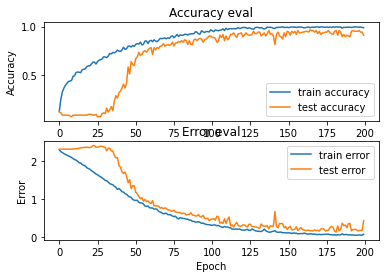

5/5 - 0s - loss: 0.0804 - accuracy: 0.9935 - 35ms/epoch - 7ms/step

Test accuracy: 0.9935483932495117
Target: 0, Predicted label: [0]


In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

In [ ]:
test = np.load('./smooth_criminal.npy')

In [ ]:
test.shape

(31, 180, 18)

In [ ]:
score = model.predict(test)

In [ ]:
p = np.argmax(score, axis=1)
p

array([2, 2, 2, 2, 5, 2, 2, 2, 2, 8, 6, 0, 8, 6, 6, 0, 0, 8, 8, 8, 0, 0,
       0, 8, 0, 0, 0, 0, 0, 8, 8])

In [ ]:
np.save('./smooth_criminal_genre.npy', p)

In [ ]:
# motion_labels = 'gBR gHO gJB gJS gKR gLH gLO gMH gPO gWA'.split()

In [ ]:
max = np.zeros(10)
for i in p:
  max[i] += 1
print( max )

[11.  0.  8.  0.  0.  1.  3.  0.  8.  0.]


In [ ]:
import seaborn as sns
import tensorflow as tf

pred = model.predict(X_test)
genres = 'break pop lock middle-hiphop LA-style-hiphop house waack krump street-jazz ballet-jazz'.split()
y_pred = np.argmax(pred, axis=1)
# y_pred.shape
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=genres,
            yticklabels=genres,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

NameError: ignored

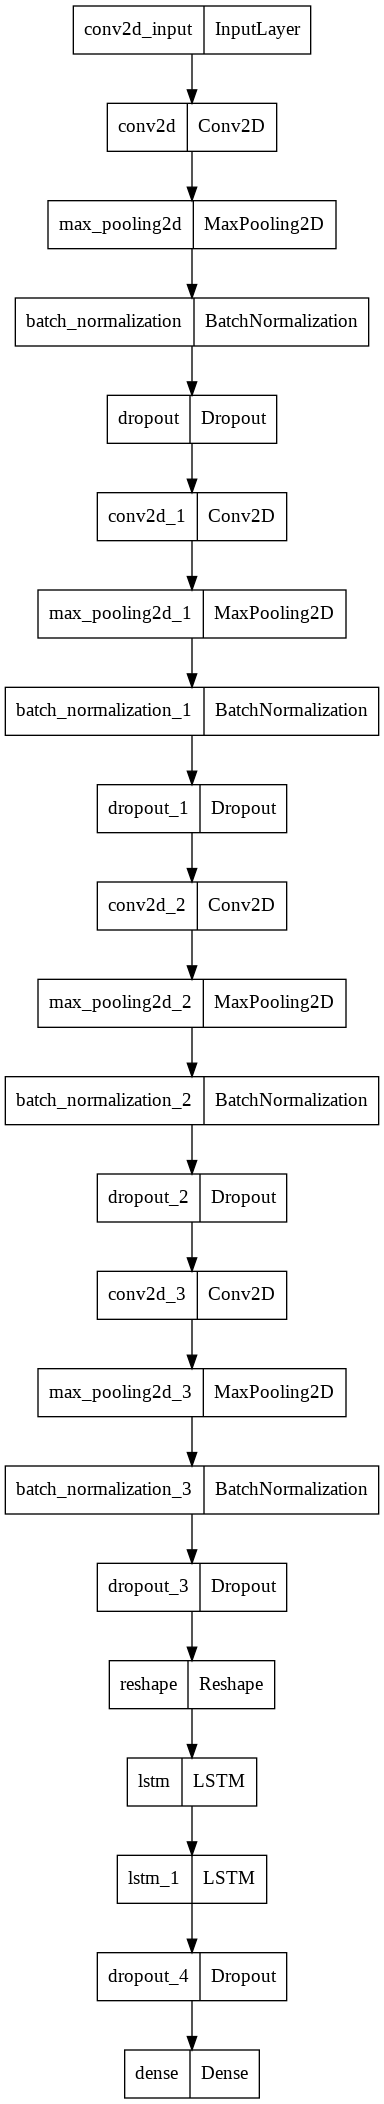

In [ ]:
# 畫 model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model.save('./drive/MyDrive/model/music_classification/use_mfcc_mint_crnn_shape_180_18.h5', model)

#$RNN-LSTM-Network-for-Music-Genre-Classification$

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "./drive/MyDrive/data/data_10.json"


def load_data(data_path):
  """Loads training dataset from json file.
      :param data_path (str): Path to json file containing data
      :return X (ndarray): Inputs
      :return y (ndarray): Targets
  """

  with open(data_path, "r") as fp:
      data = json.load(fp)

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  return X, y


def plot_history(history):
  """Plots accuracy/loss for training/validation set as a function of the epochs
      :param history: Training history of model
      :return:
  """

  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()

In [ ]:
def prepare_datasets(test_size, validation_size):
  """Loads data and splits it into train, validation and test sets.
  :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
  :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
  :return X_train (ndarray): Input training set
  :return X_validation (ndarray): Input validation set
  :return X_test (ndarray): Input test set
  :return y_train (ndarray): Target training set
  :return y_validation (ndarray): Target validation set
  :return y_test (ndarray): Target test set
  """

  # load data
  X, y = load_data(DATA_PATH)

  # create train, validation and test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

  return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
  """Generates RNN-LSTM model
  :param input_shape (tuple): Shape of input set
  :return model: RNN-LSTM model
  """

  # build network topology
  model = keras.Sequential()
  # 2 LSTM layers
  model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
  model.add(keras.layers.LSTM(64))
  model.add(keras.layers.Dropout(0.1))
  # dense layer
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))
  # output layer
  model.add(keras.layers.Dense(10, activation='softmax'))

  return model

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, 
            validation_data=(X_validation, y_validation), 
            batch_size=32, 
            epochs=100)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-tra

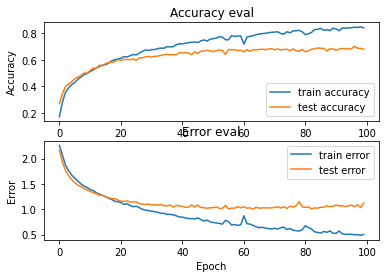

79/79 - 0s - loss: 1.2409 - accuracy: 0.6647 - 453ms/epoch - 6ms/step

Test accuracy: 0.6646658778190613


In [ ]:
# plot accuracy/error for training and validation
plot_history(history)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

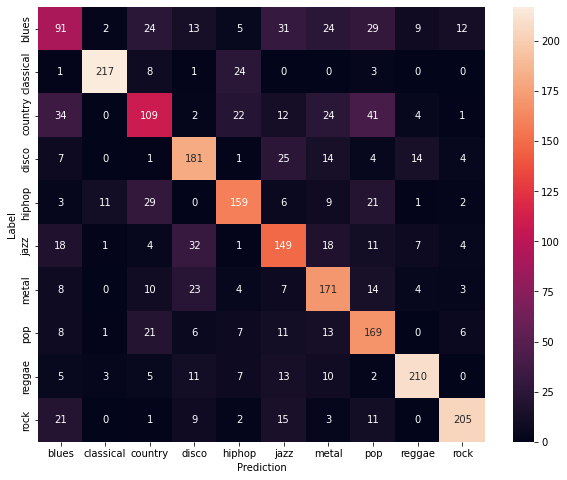

In [ ]:
import seaborn as sns
import tensorflow as tf

pred = model.predict(X_test)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
y_pred = np.argmax(pred, axis=1)
# y_pred.shape
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=genres,
            yticklabels=genres,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);